Copyright 2023 ICUBE Laboratory, University of Strasbourg

License: Apache License, Version 2.0

Author: Thibault Poignonec (thibault.poignonec@gmail.com)

Created on Tue Oct 2023

In [16]:
import numpy as np
from scipy.linalg import block_diag
import os
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

dt = 1/25

# robot geometry and workspace
diameter_pulley = 0.005 # q_data = motor_position * diameter_pulley
D = 0.01                # diameters endoscope
theorical_c_angle_max_amplitude = np.pi/4 * D / (2 * np.sqrt(2))
theorical_c_angle_amplitude =  np.array([-theorical_c_angle_max_amplitude, theorical_c_angle_max_amplitude])

# Define backlash multi-dof block model

In [4]:
import backlash_simulation_examples.models.backlash.one_dof_backlash_alternative_parameterization as b1d_bis
# import models.backlash.one_dof_backlash as b1d
import backlash_simulation_examples.models.backlash.multi_dof_backlash as bNd

def create_2dof_backlash_model(b_0 : list, gamma : list, slopes : list, q_offsets : list):
    # Define backlash for DoF n°1
    B_1 = b1d_bis.Backlash(
        q_label = "q_1", q_unit = "m",
        c_label = 'c_1 (cable length)', c_unit = 'm'
    )
    theta_1 = np.array([b_0[0], gamma[0]])
    B_1.set_fixed_parameters(m_0=slopes[0], C_0=q_offsets[0])

    # Define backlash for DoF n°2
    B_2 = b1d_bis.Backlash(
        q_label = "q_2", q_unit = "m",
        c_label = 'c_2 (cable length)', c_unit = 'm'
    )
    theta_2 = np.array([b_0[1], gamma[1]])
    B_2.set_fixed_parameters(m_0=slopes[1], C_0=q_offsets[1])

    # Combine in a 2 DoF backlash object
    backlash_model = bNd.MultiDofBacklash([B_1, B_2])
    return backlash_model, theta_1, theta_2

# Build end-to-end robot model

In [28]:
# 3 dof endoscopic tool
from backlash_simulation_examples.models.model_endoscope_two_bending_3D import EndoscopeTwoBendingModel, approx_jacobian

class SystemModel :
    def __init__(self, nb_visual_features, b_0, gamma = [0., 0.], slopes = [1., 1.], q_offsets = [0., 0.]) :
        # Create endoscope model
        self.endoscope_kin_model = EndoscopeTwoBendingModel(L_f = 0.09, L_t = 0.01, D = 0.01)
        self.endoscope_kin_model.init_default_camera_model()
        # Load backlash model
        self.backlash_model, self.theta_1, self.theta_2 = create_2dof_backlash_model(b_0, gamma, slopes, q_offsets)
        # Init nb_visual_features (mutable if needed)
        self.nb_visual_features = nb_visual_features

    def update_state_transition_model(self, x_k_1, q_k, q_k_1):
        self.backlash_model.evaluate(
                                x_k_1   = x_k_1,
                                q_k     = q_k,
                                q_k_1   = q_k_1
        )
        # Update map
        self.map_x_to_c = np.zeros((q_k.shape[0], x_k_1.shape[0]))
        self.map_x_to_c[:, :max(self.backlash_model.x_i_indexes[-1])+1] = self.backlash_model.map_x_to_c.copy()

    def f(self,  x_k_1, q_k):
        x_k = x_k_1.copy()
        x_k[:max(self.backlash_model.x_i_indexes[-1])+1] = self.backlash_model.f(x_k_1, q_k)
        return x_k

    def h(self, x_k) :
        c_k = self.map_x_to_c @ x_k
        z_hat = np.zeros((2*self.nb_visual_features,))

        for idx_feature in range (self.nb_visual_features) :
            z_i = self.endoscope_kin_model.image_measurment_from_Fb(c_k, x_k[self.p_i_indexes[idx_feature]])
            z_hat[range(int(2*float(idx_feature)),int(2*(1+float(idx_feature))))] = z_i.reshape((-1,))
        return z_hat.reshape((-1,1))

    #--------
    # Utils
    #--------
    @property
    def p_i_indexes(self) :
        p_i_indexes = []
        last_end_idx = max(self.backlash_model.x_i_indexes[-1])
        for i in range(self.nb_visual_features):
            p_i_indexes.append(range(last_end_idx+1, last_end_idx+1+3))
            last_end_idx = last_end_idx+3
        return p_i_indexes

    @property
    def expected_X_length(self) :
        return max(self.backlash_model.x_i_indexes[-1])+1+3*self.nb_visual_features

    def get_x_i(self, x_k, i) : # Attention, x_1 -> i = 1 (pas de 0 !!!)
        if x_k.shape[0] > self.expected_X_length :
            # Table
            return x_k[:,self.backlash_model.x_i_indexes[i-1]]
        else :
            # Vector
            return np.reshape(x_k[self.backlash_model.x_i_indexes[i-1]], (-1,))

    def get_c_i(self, x_k, i) : # Attention, x_1 -> i = 1 (pas de 0 !!!)
        if x_k.shape[0] >  self.expected_X_length:
            # Table
            return self.get_x_i(x_k, i)[:,0]
        else :
            # Vector
            return self.get_x_i(x_k, i)[0]

    def get_backlash_widths(self, x_k) :
        x_type = None
        if x_k.shape[0] > self.expected_X_length :
            b_widths = np.zeros((x_k.shape[0],2))
            for k in range(x_k.shape[0]) :
                b_widths[k,:] = self.backlash_model.equivalent_backlash_width(x_k[k, :max(self.backlash_model.x_i_indexes[-1])])
        else :
            return self.backlash_model.equivalent_backlash_width(x_k[:max(self.backlash_model.x_i_indexes[-1])])

    def get_c_from_x_k(self, x_k) :
        return np.array([self.get_c_i(x_k, 1), self.get_c_i(x_k, 2)])

    def get_p_i(self, x_k, i) :
        if x_k.shape[0] > self.expected_X_length :
            # Table
            return x_k[:,self.p_i_indexes[i-1]]
        else :
            # Vector
            return np.reshape(x_k[self.p_i_indexes[i-1]], (-1,))

    def get_z_i(self, z_k, i) :
        if z_k.shape[0] > 2*self.nb_visual_features :
            # Table
            return  z_k[:,int((i-1)*2):int((i)*2)]
        else :
            # Vector
            return np.reshape(z_k[int((i-1)*2):int((i)*2)], (-1,))

# Simulate system

In [39]:
def generate_dummy_data() :
    # time
    t_max = 3*60
    t = np.arange(0.0, t_max, dt)

    # Visual features
    depth_inner_pts = 0.2
    depth_outer_pts = 0.2

    inner_d = 0.01
    outer_d = 0.02

    list_real_pts_in_Fb = []
    #list_real_pts_in_Fb.append(np.array([0, 0, depth_inner_pts - 0.01]))
    list_real_pts_in_Fb.append(np.array([inner_d, inner_d, depth_inner_pts]))
    list_real_pts_in_Fb.append(np.array([-inner_d, inner_d,depth_inner_pts- 0.01]))
    list_real_pts_in_Fb.append(np.array([-inner_d, -inner_d, depth_inner_pts]))
    list_real_pts_in_Fb.append(np.array([inner_d, -inner_d, depth_inner_pts- 0.01]))

    nb_visual_features = len(list_real_pts_in_Fb)

    print(nb_visual_features, " scene landmarks generated.")

    # "Real" model parameters + generate c data
    real_b_widths = [np.pi/12  * D/2, np.pi/12.0  * D/2]

    pratical_simulation_beta_max = np.pi/8 # RQ: can change due to backlash!!! This is why we add it later with "c_max_1 = c_max + real_b_widths[0]/2"
    c_max = pratical_simulation_beta_max * D /(2* np.sqrt(2)) # See notebook page 68-69 for details
    c_max_1 = c_max + real_b_widths[0]/2
    c_max_2 = c_max + real_b_widths[1]/2

    c_min_values = np.array([-c_max_1, -c_max_2])
    c_max_values = np.array([ c_max_1,  c_max_2])
    q_min_values = c_min_values.copy()
    q_max_values = c_max_values.copy()
    range_q = abs(q_max_values - q_min_values)

    # Generate  dummy q data
    q_1 = 2*np.sin(np.pi/17*t) + 4*np.cos(np.pi/2*t)*np.exp(-t/10) + 3*np.sin(np.pi/4*t) - 3*np.sin(np.pi/6*t)
    q_2 = np.sin(np.pi/5*t) - 8*np.sin(np.pi/2*t)*np.exp(-t/5) + 5*np.cos(np.pi/4*t) - 2*np.sin(np.pi/10*t)
    q_data = np.zeros((q_1.shape[0], 2))
    for q_i, i in zip([q_1, q_2], [0,1]) :
        q_data[:,i] = q_i.copy()
        q_data[:,i] = q_data[:,i] - np.min(q_data[:,i])
        q_data[:,i] = q_data[:,i]/np.max(q_data[:,i]) * (q_max_values[i] - q_min_values[i]) + q_min_values[i]

    std_noise_z = 3 # in px

    # 'Real' system
    real_system = SystemModel(
        nb_visual_features = nb_visual_features,
        b_0 = [
            real_b_widths[0],
            real_b_widths[1]],
        gamma = [0.2, -0.1],
        slopes = [1.1, 1.1],
        q_offsets = [-np.pi/20 * D/2, np.pi/20 * D/2]
    )
    real_system.endoscope_kin_model.camera_model_params_["rotation_camera_wrt_bearing"] = 0.0 #2/180*np.pi


    # Simulate sytem
    x_data = np.zeros((t.shape[0], real_system.backlash_model.x_dim + 3*nb_visual_features))
    x_data[0,:] = np.concatenate([
            np.array([0]), real_system.theta_1,
            np.array([0]), real_system.theta_2,
        ] +  list_real_pts_in_Fb
    )
    z_data = np.zeros((t.shape[0], 2*nb_visual_features))

    for k in tqdm(range(1,t.shape[0])):
        q_k = np.copy(q_data[k,:])
        q_k_1 = np.copy(q_data[k-1,:])
        x_k_1 = np.copy(x_data[k-1,:])
        # Update system state
        real_system.update_state_transition_model(x_k_1 = x_k_1, q_k = q_k, q_k_1 = q_k_1)
        x_data[k,:] = real_system.f(x_k_1 = x_k_1, q_k = q_k).reshape((-1,))
        z_data[k,:] = real_system.h(x_data[k,:]).reshape((-1,))

    # Clean first time step (undefined)
    q_data[0,:] = q_data[1,:].copy()
    x_data[0,:] = x_data[1,:].copy()
    z_data[0,:] = z_data[1,:].copy()

    # Add measurement noise to z
    noise_z_data = np.random.normal(0,std_noise_z, z_data.shape[0]*z_data.shape[1]).reshape(z_data.shape)
    z_data += noise_z_data

    # Extract config vars
    c_data = np.zeros(q_data.shape)
    c_data[:,0] = x_data[:, real_system.backlash_model.c_i_indexes[0]]
    c_data[:,1] = x_data[:, real_system.backlash_model.c_i_indexes[1]]

    # Compute robot tip position wrt base
    real_robot_tip_in_base = np.zeros((t.shape[0],3))
    for k in range(t.shape[0]) :
        real_robot_tip_in_base[k,:] = real_system.endoscope_kin_model.t_base_to_tip(c_data[k,:]).reshape((-1,))

    return {
        't_data': t,
        'q_data': q_data,
        'c_data': c_data,
        'x_data': x_data,
        'z_data': z_data,
        'z_noise_component': noise_z_data,
        'robot_tip_in_base' : real_robot_tip_in_base,
        'system_model' : real_system,
        'nb_visual_features': nb_visual_features,
        }

# Generate dummy experimental data
simulation_data = generate_dummy_data()
real_system = simulation_data['system_model']

5  scene landmarks generated.


100%|██████████| 4499/4499 [00:01<00:00, 4373.02it/s]


# Plotting

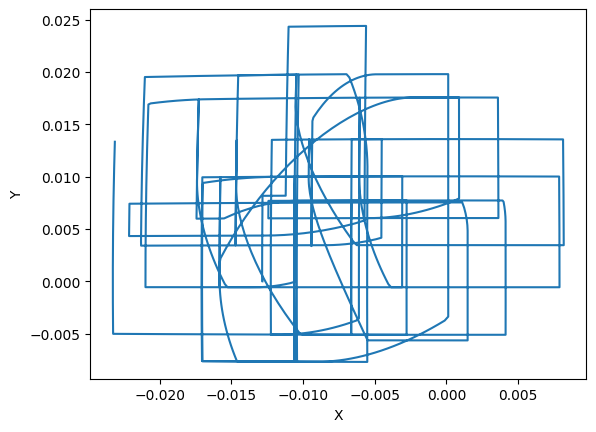

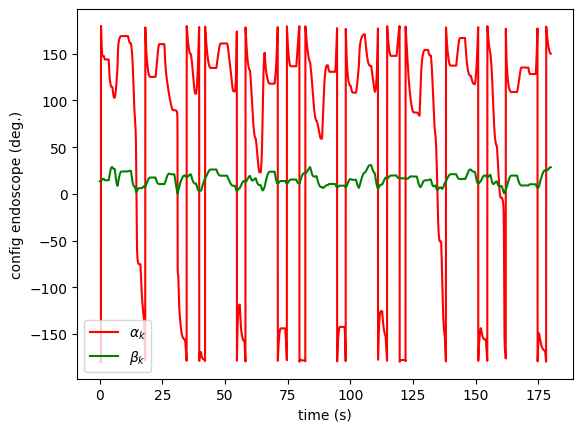

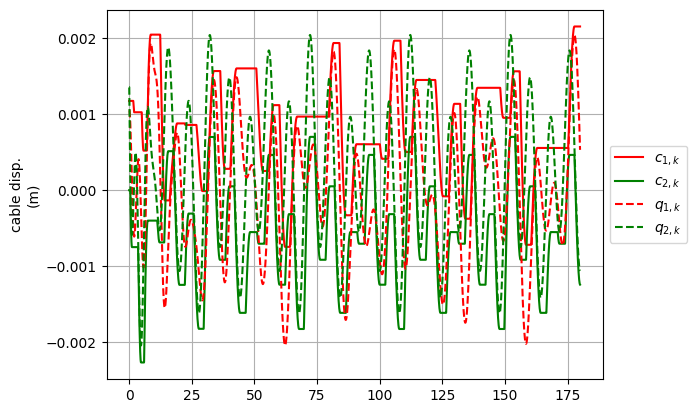

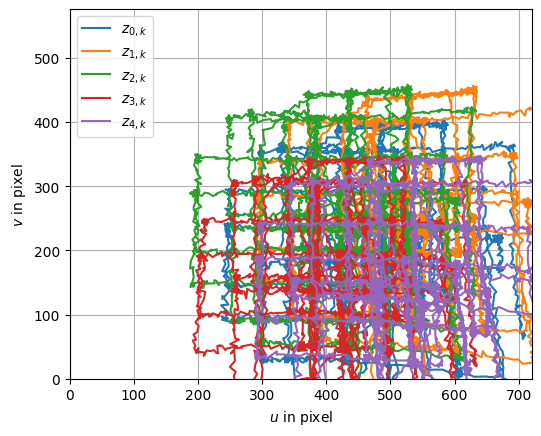

In [41]:
def plot_dummy_data(dummy_data_dict) :
    t_data = dummy_data_dict.get("t_data")
    q_data = dummy_data_dict.get("q_data")
    c_data = dummy_data_dict.get("c_data")
    z_data = dummy_data_dict.get("z_data")
    system_model = dummy_data_dict.get('system_model')

    if system_model is None :
        raise Exception("Model not defined!")

    if t_data is None :
        raise Exception("t_data not defined!")

    if q_data is None :
        raise Exception("q_data not defined!")

    # Plot robot tip position
    if "robot_tip_in_base" in dummy_data_dict.keys() :
        fig = plt.figure()
        ax1= fig.add_subplot(1,1,1)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.plot(dummy_data_dict["robot_tip_in_base"][:,0],
                 dummy_data_dict["robot_tip_in_base"][:,1],
                 label = '3D real tip traj.')

    if c_data is not None :
        # Plot alpha and beta
        c_angles_data = np.zeros(q_data.shape)
        for k in range(q_data.shape[0]) :
            c_angles_data[k, :] = \
                real_system.endoscope_kin_model.func_c_cables_to_c_angles_(c_data[k,:]).reshape((-1,))

        fig = plt.figure()
        ax1= fig.add_subplot(1,1,1)
        ax1.plot(t_data, c_angles_data[:,0]*180/np.pi, 'r', label = r'$\alpha_{k}$')
        ax1.plot(t_data, c_angles_data[:,1]*180/np.pi, 'g', label = r'$\beta_{k}$')
        ax1.set_ylabel('config endoscope (deg.)')
        ax1.set_xlabel('time (s)')
        ax1.legend()

        #Plot c
        fig = plt.figure()
        ax1= fig.add_subplot(1,1,1)
        ax1.plot(t_data, c_data[:,0], 'r', label = r'$c_{1,k}$')
        ax1.plot(t_data, c_data[:,1], 'g', label = r'$c_{2,k}$')
        ax1.plot(t_data, q_data[:,0], 'r--', label = r'$q_{1,k}$')
        ax1.plot(t_data, q_data[:,1], 'g--', label = r'$q_{2,k}$')
        ax1.grid()
        ax1.set_ylabel('cable disp.\n(m)')
        ax1.legend(frameon=True, loc='center left', bbox_to_anchor=(1, 0.5))

    # Plot image trajectory
    fig = plt.figure()
    ax_img = fig.add_subplot(1,1,1)

    ax_img.set_xlim(real_system.endoscope_kin_model.camera_model_params_["u_lims"])
    ax_img.set_ylim(real_system.endoscope_kin_model.camera_model_params_["v_lims"])
    ax_img.set_aspect('equal')
    #lc = colored_line_plot(ax_img, z_1_data[:,0], z_1_data[:,1], t, r"$z_{1,k}$")
    #cbar = plt.colorbar(lc, ax = ax_img)
    #cbar.ax.set_ylabel(r'$t$ (s)', rotation=0)

    for idx_feature in range (real_system.nb_visual_features) :
        z_i_data = real_system.get_z_i(z_data, idx_feature+1)
        ax_img.plot(z_i_data[:,0],
                    z_i_data[:,1],
                    label =  r"$z_{"+ str(int(idx_feature)) + r",k}$")
    ax_img.grid()
    ax_img.legend()
    ax_img.set_xlabel(r'$u$ in pixel')
    ax_img.set_ylabel(r'$v$ in pixel')

plot_dummy_data(simulation_data)